In [352]:
import pandas as pd
import numpy as np

### Đọc dữ liệu

In [353]:
data = pd.read_excel("Data/champagne_new.xlsx",index_col=0)
data.head()

,monthly_champange
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [354]:
data.index = pd.to_datetime(data.index)
data.index.freq = 'MS'
data.head()

,monthly_champange
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [355]:
import matplotlib.pyplot as plt
def Visualize_aSerie(series,title,period=12):
    plt.figure(figsize=(12,6))
    plt.plot(series)
    plt.plot(series.rolling(window=period,center=True).mean())
    plt.title(title)
    plt.show()

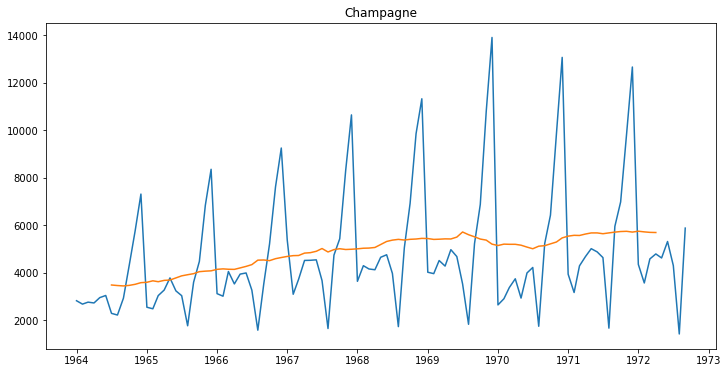

In [356]:
Visualize_aSerie(data,'Champagne',12)

### Decomposition

In [360]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative',
                           extrapolate_trend='freq')

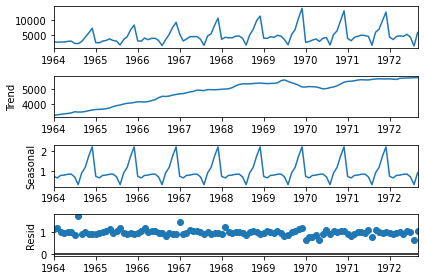

In [361]:
result.plot()
plt.show()

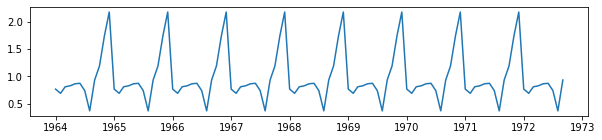

In [315]:
plt.figure(figsize=(10,2))
plt.plot(result.seasonal)

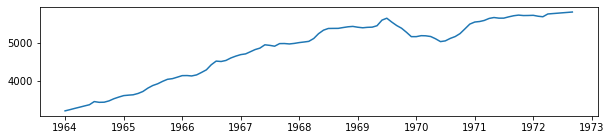

In [316]:
plt.figure(figsize=(10,2))
plt.plot(result.trend)

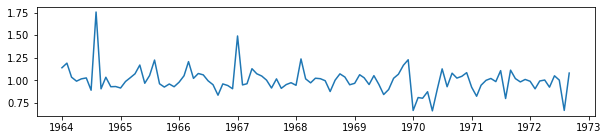

In [317]:
plt.figure(figsize=(10,2))
plt.plot(result.resid)

### Chia dữ liệu train/test

In [359]:
train = data.loc['1964-01-01':'1970-03-01']
test = data.loc['1970-04-01':]
test.shape

(30, 1)

### Áp dụng Holt-Winters

In [319]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0],end=test.index[-1])

C:\Users\quynh\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


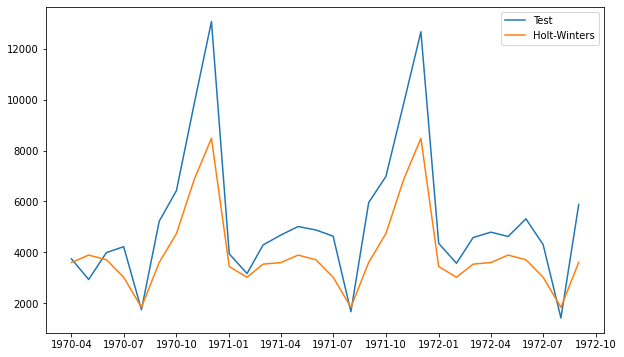

In [320]:
plt.figure(figsize=(10,6))
# plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

In [321]:
data.tail()

,monthly_champange
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


In [322]:
import datetime
s = datetime.datetime(1972, 10, 1)
e = datetime.datetime(1973, 6, 1)
pred_next_9_month = model.predict(start= s, end=e)
pred_next_9_month

1972-10-01    4732.448725
1972-11-01    6860.434071
1972-12-01    8480.222257
1973-01-01    3435.722713
1973-02-01    3014.340167
1973-03-01    3530.513621
1973-04-01    3592.846556
1973-05-01    3887.118924
1973-06-01    3702.904922
Freq: MS, dtype: float64

In [323]:
x = pd.Series(pred_next_9_month)
type(x)

pandas.core.series.Series

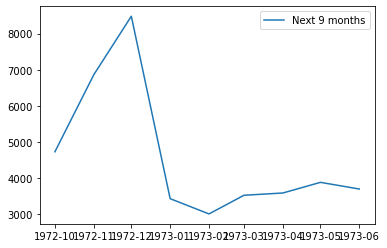

In [324]:
plt.plot(x.index, x.values, label='Next 9 months')
plt.legend(loc='best')

### Trực quan hóa dữ liệu

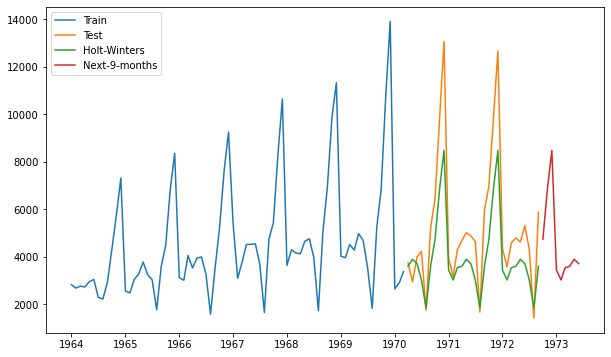

In [343]:
plt.figure(figsize=(10,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.plot(x.index, x.values, label='Next-9-months')
plt.legend(loc='best')

### Áp dụng auto_arima để xây dựng mô hình

In [326]:
from pmdarima import auto_arima

In [327]:
auto_model = auto_arima(train, max_p=5, max_q=5, m=12, d=1,
                           start_P=1, seasonal=True,
                           D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1012.913, Time=0.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1035.352, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1026.899, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1009.144, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1007.179, Time=0.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1009.122, Time=0.24 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1008.251, Time=0.17 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1008.044, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1026.112, Time=0.02 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1007.465, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 2.403 seconds


In [328]:
auto_model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [329]:
auto_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [330]:
future_forecast = auto_model.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
future_forecast.head()

,Prediction
Month,
1970-04-01,4474.768629
1970-05-01,5166.768629
1970-06-01,4875.768629
1970-07-01,3721.768629
1970-08-01,2019.768629


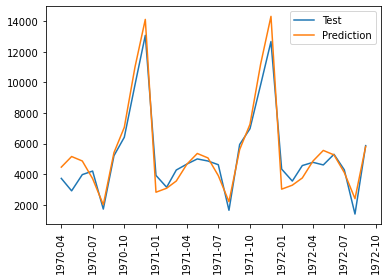

In [331]:
plt.plot(test, label='Test')
plt.plot(future_forecast, label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

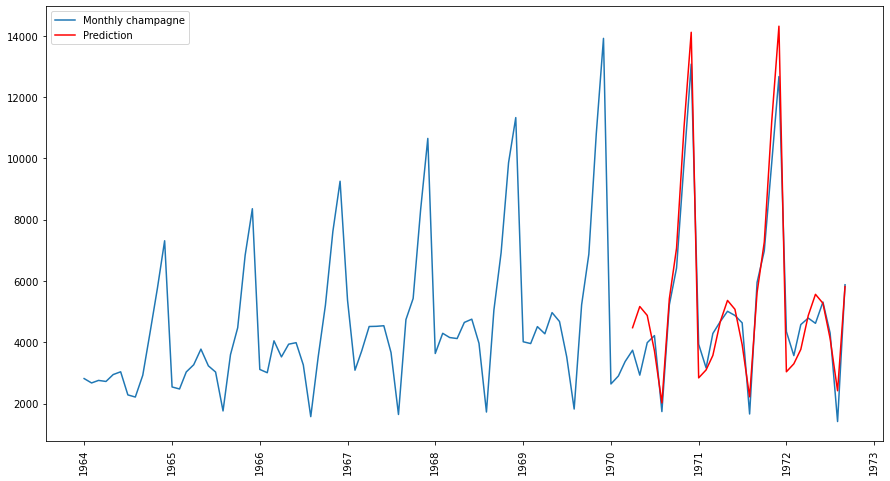

In [332]:
plt.figure(figsize=(15,8))
plt.plot(data, label='Monthly champagne')
plt.plot(future_forecast, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [333]:
#Dự đoán 9 tháng tiếp theo
future_forecast_next9months = auto_model.predict(n_periods=len(test)+9)
future_forecast_next9months

array([ 4474.7686292,  5166.7686292,  4875.7686292,  3721.7686292,
        2019.7686292,  5420.7686292,  7070.7686292, 11001.7686292,
       14114.7686292,  2837.7686292,  3097.7686292,  3568.7686292,
        4673.5372584,  5365.5372584,  5074.5372584,  3920.5372584,
        2218.5372584,  5619.5372584,  7269.5372584, 11200.5372584,
       14313.5372584,  3036.5372584,  3296.5372584,  3767.5372584,
        4872.3058876,  5564.3058876,  5273.3058876,  4119.3058876,
        2417.3058876,  5818.3058876,  7468.3058876, 11399.3058876,
       14512.3058876,  3235.3058876,  3495.3058876,  3966.3058876,
        5071.0745168,  5763.0745168,  5472.0745168])

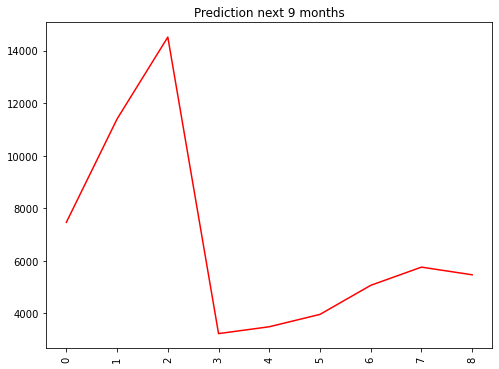

In [334]:
plt.figure(figsize=(8,6))
plt.plot(future_forecast_next9months[len(test):], color='red')
plt.xticks(rotation='vertical')
plt.title("Prediction next 9 months")
plt.show()

In [345]:
next_9_months=future_forecast_next9months[len(test):]

In [336]:
months = pd.date_range('1972-10-01','1973-06-01', 
              freq='MS').strftime("%Y-%m-%d").tolist()

In [347]:
x=pd.Series(next_9_months, index=months)
type(x)

pandas.core.series.Series

In [337]:
new_predict = pd.DataFrame({
    'Month' : months,
    'monthly_champange': next_9months}    
    )
new_predict.set_index('Month',inplace=True)
new_predict

,monthly_champange
Month,
1972-10-01,7468.305888
1972-11-01,11399.305888
1972-12-01,14512.305888
1973-01-01,3235.305888
1973-02-01,3495.305888
1973-03-01,3966.305888
1973-04-01,5071.074517
1973-05-01,5763.074517
1973-06-01,5472.074517


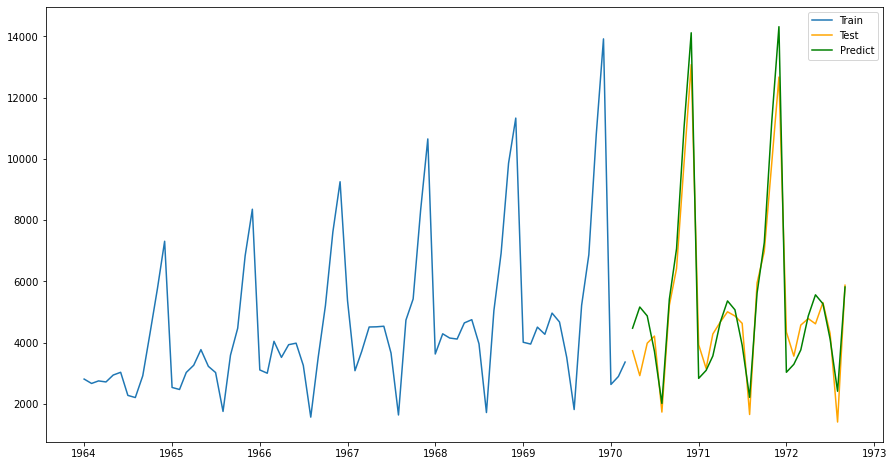

In [349]:
plt.figure(figsize=(15,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(future_forecast.index, future_forecast, label='Predict', color='green')
# plt.plot(x.index, x, label='Next-9-months', color='red')
plt.legend(loc='best')